## Compare variants

### 1. For each clone-variant, calculate the mean af difference between that clone-variant and other clone-variant
### 2. Sort the variants by ranking
### 3. Calculate the position of each clone's variant in the rankings 
### 4. Plot: each clone's mean ranking of the variants of interest 
### 5. Metric: 1/(Average ranking of variants in clone)

In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]


ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"
dirs = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/Control/MT/cellr_True/numread_200/"

pileups_indir = "/data/Mito_Trace/output/clone_pileups_simulation/"
predict_indir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/"

outdir =  "/data/Mito_Trace/output/clone_pileups_simulation/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/pred_vs_known/"
to_test = False



In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)



import mplh.cluster_help as ch

fig_utils from mplh
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)


curr_pileups_indir = join(pileups_indir, curr_out_meta, curr_out_seq)



donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


## Load data

In [4]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [5]:
don_vars_df = pd.read_csv(join(curr_pileups_indir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(curr_pileups_indir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(curr_pileups_indir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(curr_pileups_indir, "clones_meta.csv"), index_col=0)

In [6]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest.index = [x.replace(">","") for x in vars_of_interest.index]
clone_vars = vars_of_interest[(~(vars_of_interest["clone"].isnull()))].astype(object)

#clone_vars["lineage"] = clone_vars["clone"].apply(lambda x: x.split("cl")[-1]).astype(object)
#clone_vars["name"] = clone_vars.apply(lambda x: f'{x["donor"]}_{x["lineage"]}',axis=1)
clone_vars

,donor,clone
7369T,0,d0cl0
6842A,0,d0cl0
7151T,0,d0cl1
15306G,0,d0cl1
4225C,0,d0cl2
2841C,0,d0cl2
5663G,0,d0cl2
2549A,0,d0cl3
1972G,0,d0cl3
15378A,0,d0cl3


In [7]:
predict_barcodes_d = {}
for d in range(n_donors):
    predict_barcodes_d[str(d)] = pd.read_csv(join(predict_indir, f"barcodes/btwnClones_dendro_dt_0.6/donor{d}.mean.csv"), 
                                        index_col=0)

    if ">" in predict_barcodes_d[str(d)].columns[0]:
        # mgatkdonor 
        predict_barcodes_d[str(d)].columns = [x.split(">")[0][:-1] +  x.split(">")[-1] for x in predict_barcodes_d[str(d)].columns]

In [8]:
def calc_mean_diff(barcode_ser, clone_id):
    return (barcode_ser.loc[clone_id] - barcode_ser.drop(clone_id)).mean()

def get_var_clone(var_ser, barcodes_d):
    d_max = -1
    cl_max = -1
    max_diff = -np.infty
    for d in barcodes_d:
        if var_ser.name in barcodes_d[d].columns:
            curr_barcode = barcodes_d[d][var_ser.name]
            clone_diffs = []

            for curr_cl in curr_barcode.index:
                clone_diffs.append(calc_mean_diff(curr_barcode,curr_cl))
            print('clone_diffs',  max(clone_diffs))
            curr_max = max(clone_diffs)
            if curr_max>max_diff:
                cl_max = curr_barcode.index[np.array(clone_diffs).argmax()]
                max_diff = curr_max
                d_max = d
        
    return pd.Series({"pred_donor":str(d_max), "pred_clone":cl_max, "pred_diff": max_diff })




In [9]:
pred_clone_vars = clone_vars.apply(get_var_clone, args=(predict_barcodes_d,),axis=1, result_type='expand')
clone_vars = pd.concat((clone_vars,pred_clone_vars),axis=1)
clone_vars

clone_diffs 0.5618622071297888
clone_diffs 0.0019750063051038502
clone_diffs 0.5639977295418945
clone_diffs 0.0005692998236809001
clone_diffs 0.5675474411831161
clone_diffs 0.00045728976669342505
clone_diffs 0.565705534839331
clone_diffs 0.00043278821139034005
clone_diffs 0.568666079826563
clone_diffs 0.0004794168088060473
clone_diffs 0.5566430187136984
clone_diffs 0.00073924765113859
clone_diffs 0.5627696483205742
clone_diffs 0.00016884127416062455
clone_diffs 0.5631977668429131
clone_diffs 0.00012693177943102498
clone_diffs 0.5652674384140136
clone_diffs 0.0003088495948701667
clone_diffs 0.5603504569473754
clone_diffs 0.0005051055640306553
clone_diffs 0.5658621058327767
clone_diffs 0.000396555264233
clone_diffs 0.0007054992323981123
clone_diffs 0.5623296541359583
clone_diffs 0.0009386566676125
clone_diffs 0.5597102513069843
clone_diffs 0.0005950236796545174
clone_diffs 0.5620747160149708
clone_diffs 0.0007463285092158597
clone_diffs 0.5663676529705846
clone_diffs 0.000461778789122499

,donor,clone,pred_donor,pred_clone,pred_diff
7369T,0,d0cl0,0,0_2,0.561862
6842A,0,d0cl0,0,0_2,0.563998
7151T,0,d0cl1,0,0_4,0.567547
15306G,0,d0cl1,0,0_4,0.565706
4225C,0,d0cl2,0,0_3,0.568666
2841C,0,d0cl2,0,0_3,0.556643
5663G,0,d0cl2,0,0_3,0.562770
2549A,0,d0cl3,0,0_0,0.563198
1972G,0,d0cl3,0,0_0,0.565267
15378A,0,d0cl3,0,0_0,0.560350


In [10]:
predict_barcodes_d["0"]

,11719A,14350G,11150T,12833T,9528G,4832A,5767T,12920G,1558G,8953G,...,6290A,6232G,8817T,12606A,1417G,14115A,6208C,15378A,1972G,2549A
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,0.877961,0.876822,0.884843,0.889115,0.889542,0.888520,0.883439,0.896597,0.890094,0.897388,...,0.000283,0.000540,0.000360,0.000385,0.000488,0.000077,0.000077,0.560452,0.565747,0.563587
0_3,0.878430,0.887030,0.886934,0.884418,0.889462,0.882583,0.885501,0.891999,0.889275,0.886934,...,0.000255,0.000165,0.000316,0.000466,0.000541,0.000135,0.000060,0.000105,0.000376,0.000361
0_4,0.889778,0.883171,0.880519,0.878738,0.881001,0.882394,0.885607,0.875572,0.885611,0.884624,...,0.000151,0.000106,0.000212,0.000091,0.000106,0.000182,0.000197,0.000106,0.001317,0.000197
0_1,0.877416,0.883618,0.896089,0.889947,0.888811,0.885621,0.884257,0.884108,0.879717,0.871870,...,0.000419,0.000236,0.000170,0.000026,0.000301,0.000079,0.000446,0.000157,0.000118,0.000485
0_2,0.886161,0.879203,0.877399,0.891178,0.882454,0.882865,0.885123,0.886678,0.891925,0.885715,...,0.000739,0.000264,0.000396,0.000185,0.000158,0.000211,0.000396,0.000040,0.000106,0.000515


In [11]:
clone_vars

,donor,clone,pred_donor,pred_clone,pred_diff
7369T,0,d0cl0,0,0_2,0.561862
6842A,0,d0cl0,0,0_2,0.563998
7151T,0,d0cl1,0,0_4,0.567547
15306G,0,d0cl1,0,0_4,0.565706
4225C,0,d0cl2,0,0_3,0.568666
2841C,0,d0cl2,0,0_3,0.556643
5663G,0,d0cl2,0,0_3,0.562770
2549A,0,d0cl3,0,0_0,0.563198
1972G,0,d0cl3,0,0_0,0.565267
15378A,0,d0cl3,0,0_0,0.560350


In [12]:
def get_rank_var_clone(var_ser, barcodes_d):
    if var_ser['pred_donor'] == "-1":
        return -1
    curr_d = var_ser['pred_donor']
    #print('curr_d', curr_d)
    curr_cl = var_ser['pred_clone']
    curr_v = var_ser.name
    curr_diff = var_ser["pred_diff"]
    #"Loop through each variant and calculate this clones fold for each, then see where it ranks"
    cl_ranks = []
    #print('curr_d',curr_d)
    for v in barcodes_d[curr_d].columns: 
        cl_ranks.append(calc_mean_diff(barcodes_d[curr_d][v], curr_cl))
    cl_ranks = np.array(cl_ranks)
    
    return (curr_diff <= cl_ranks).sum()
    
clone_vars["rank"] = clone_vars.apply(get_rank_var_clone,args=(predict_barcodes_d,),axis=1)
clone_vars

,donor,clone,pred_donor,pred_clone,pred_diff,rank
7369T,0,d0cl0,0,0_2,0.561862,2
6842A,0,d0cl0,0,0_2,0.563998,1
7151T,0,d0cl1,0,0_4,0.567547,1
15306G,0,d0cl1,0,0_4,0.565706,2
4225C,0,d0cl2,0,0_3,0.568666,1
2841C,0,d0cl2,0,0_3,0.556643,3
5663G,0,d0cl2,0,0_3,0.562770,2
2549A,0,d0cl3,0,0_0,0.563198,2
1972G,0,d0cl3,0,0_0,0.565267,1
15378A,0,d0cl3,0,0_0,0.560350,3


In [13]:
predict_barcodes_df = pd.concat(predict_barcodes_d).droplevel(0).fillna(0)
predict_barcodes_df

,11719A,14350G,11150T,12833T,9528G,4832A,5767T,12920G,1558G,8953G,...,6290A,6232G,8817T,12606A,1417G,14115A,6208C,15378A,1972G,2549A
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,0.877961,0.876822,0.884843,0.889115,0.889542,0.888520,0.883439,0.896597,0.890094,0.897388,...,0.000283,0.000540,0.000360,0.000385,0.000488,0.000077,0.000077,0.560452,0.565747,0.563587
0_3,0.878430,0.887030,0.886934,0.884418,0.889462,0.882583,0.885501,0.891999,0.889275,0.886934,...,0.000255,0.000165,0.000316,0.000466,0.000541,0.000135,0.000060,0.000105,0.000376,0.000361
0_4,0.889778,0.883171,0.880519,0.878738,0.881001,0.882394,0.885607,0.875572,0.885611,0.884624,...,0.000151,0.000106,0.000212,0.000091,0.000106,0.000182,0.000197,0.000106,0.001317,0.000197
0_1,0.877416,0.883618,0.896089,0.889947,0.888811,0.885621,0.884257,0.884108,0.879717,0.871870,...,0.000419,0.000236,0.000170,0.000026,0.000301,0.000079,0.000446,0.000157,0.000118,0.000485
0_2,0.886161,0.879203,0.877399,0.891178,0.882454,0.882865,0.885123,0.886678,0.891925,0.885715,...,0.000739,0.000264,0.000396,0.000185,0.000158,0.000211,0.000396,0.000040,0.000106,0.000515
1_0,0.000334,0.000103,0.000026,0.002017,0.000090,0.000103,0.000064,0.000450,0.000128,0.000167,...,0.560194,0.564525,0.886182,0.882008,0.563483,0.880486,0.884810,0.000617,0.000206,0.000257
1_4,0.000117,0.000175,0.000408,0.000379,0.000044,0.000189,0.001662,0.000102,0.000554,0.000554,...,0.000073,0.000292,0.884157,0.877895,0.000204,0.886896,0.877483,0.000714,0.000306,0.000175
1_2,0.000055,0.001191,0.000346,0.000139,0.000402,0.001870,0.000222,0.000083,0.000526,0.001191,...,0.000083,0.000222,0.884343,0.880060,0.000222,0.875500,0.890659,0.000097,0.000485,0.000180
1_1,0.000240,0.000054,0.001099,0.000095,0.000502,0.000312,0.000597,0.000068,0.000231,0.000556,...,0.000190,0.000122,0.886201,0.881001,0.000312,0.886043,0.892232,0.000095,0.000081,0.000353


In [14]:
clone_vars

,donor,clone,pred_donor,pred_clone,pred_diff,rank
7369T,0,d0cl0,0,0_2,0.561862,2
6842A,0,d0cl0,0,0_2,0.563998,1
7151T,0,d0cl1,0,0_4,0.567547,1
15306G,0,d0cl1,0,0_4,0.565706,2
4225C,0,d0cl2,0,0_3,0.568666,1
2841C,0,d0cl2,0,0_3,0.556643,3
5663G,0,d0cl2,0,0_3,0.562770,2
2549A,0,d0cl3,0,0_0,0.563198,2
1972G,0,d0cl3,0,0_0,0.565267,1
15378A,0,d0cl3,0,0_0,0.560350,3


In [15]:
clone_vars = clone_vars.loc[~(clone_vars["pred_diff"] == -np.infty)]


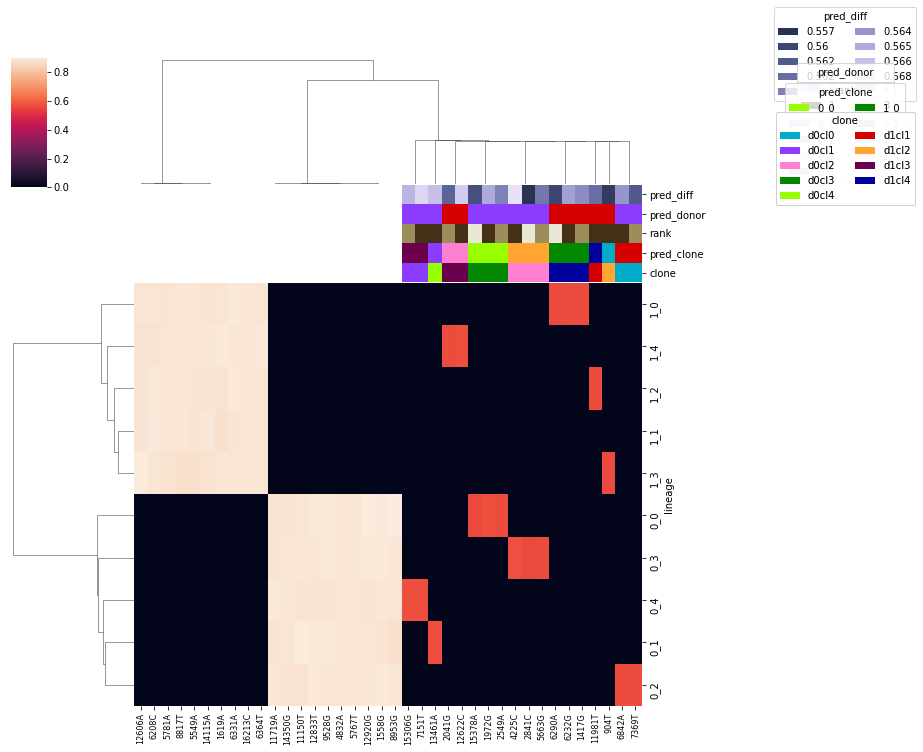

In [17]:
if clone_vars.shape[0] != 0:
    ch.plot_cluster(predict_barcodes_df.fillna(0), 
                    col_meta=clone_vars[["pred_diff","pred_donor","rank", "pred_clone", "clone"]], 
                    col_clr_schemes={"pred_diff":"sequential", "pred_clone":"categorical",
                                     "pred_donor":"categorical","clone":"categorical",
                                      "rank":"sequential"})

    #"pred_clone"

## Variants of same position!